In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch import optim
import torch.optim as optim
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
# Open the files:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label)
train_fh 

<_io.BufferedReader name='lego-train.pickle'>

In [6]:
train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)


C:\Users\Acer\AppData\Local\Temp\ipykernel_7196\1252107873.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  tensor_x = torch.Tensor(X) # transform to torch tensor


In [7]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


Original shape is  torch.Size([48, 48, 1])


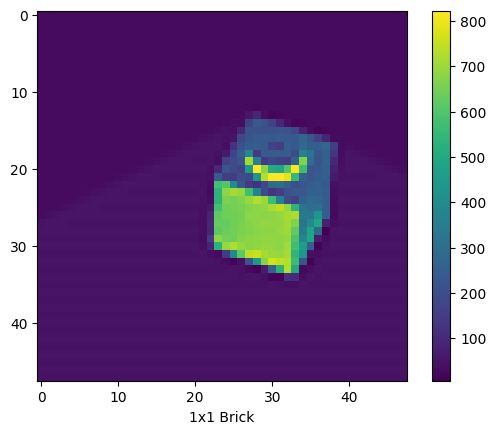

In [8]:
# the same, but with torch dataset
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

In [9]:
# Define a neural network as per the original lab
def build_NN():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48*48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [10]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [11]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [12]:
net = build_NN()
net.to(device)
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


In [13]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 200
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 199, Batch: 14, Loss: 10.64, Acc: 1.00: 100%|██████████| 3000/3000 [00:11<00:00, 270.44it/s]


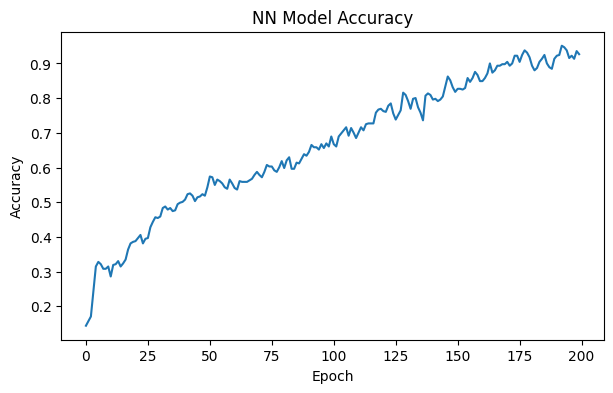

In [14]:
print_history(hist, "NN Model Accuracy")

In [15]:
max(hist)

0.9512195121951219

In [16]:

def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(1, 6, 5, padding=(2,2)), # out: 48x48x6
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(6, 16, 5), # out: 20x20x16
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16

        torch.nn.Flatten(),
        
        torch.nn.Linear(10*10*16, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net


In [17]:
lenet = build_lenet()
lenet.to(device)
print(lenet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)


Epoch: 49, Batch: 14, Loss: 21.56, Acc: 1.00: 100%|██████████| 750/750 [00:04<00:00, 167.33it/s]


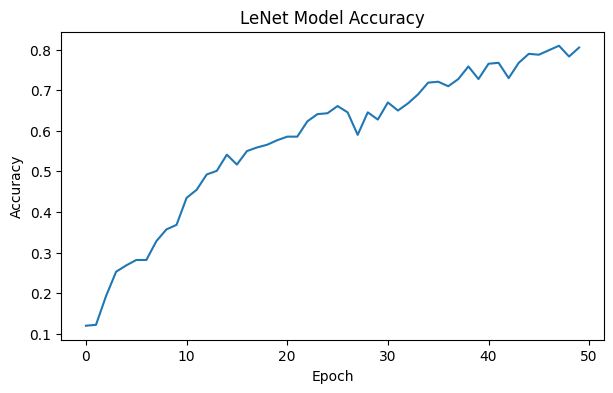

In [19]:
print_history(hist_lenet, "LeNet Model Accuracy")

In [20]:
max(hist_lenet)

0.8093126385809313

In [21]:
def objective(trial):
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    EPOCHS = trial.suggest_int("epochs", 30, 70)
    LR = trial.suggest_loguniform("lr", 0.001, 0.005)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    model = lenet.to(device)
    hist_lenet = train(model, train_dataloader, device, EPOCHS, LR)

    val_accuracy = hist_lenet[-1]
    
    return 1.0 - val_accuracy

#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=12)

#print("Best hyperparameters:", study.best_params)

In [22]:
BATCH_SIZE = 16
EPOCHS = 69
LR = 0.0024

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)


Epoch: 68, Batch: 28, Loss: 1.96, Acc: 1.00: 100%|██████████| 2001/2001 [00:09<00:00, 208.14it/s]


In [23]:
def evaluate_acc(net, test_loader, device):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc


In [24]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [25]:
net_acc = evaluate_acc(net, test_dataloader, device)
lenet_acc = evaluate_acc(lenet, test_dataloader, device)

print('Test Accuracy (NN): {:.2%}'.format(net_acc))
print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))

Test Accuracy (NN): 94.00%
Test Accuracy (LeNet): 100.00%


In [26]:
def show_random(net, dataloader):
    train_image_no = 89

    def get_prediction(net, input):
        input = input.permute(2, 0, 1).to(device)
        outputs = net(input)        
        _, predicted = outputs.max(1)
        return predicted


    images_data, original_label = next(iter(dataloader))
    images_data = images_data[0]
    original_label = original_label[0]
    
    predicted_label = get_prediction(net, images_data)
    print('original_label ', original_label) 
    print('predicted_label ', predicted_label)
    if original_label == predicted_label[0]: 
        c = 'green' 
    else:
        c = 'red'
        
    plt.figure()
    plt.imshow(images_data.numpy())
    plt.colorbar()

    plt.xlabel(class_names[predicted_label], color = c)
    plt.show()


original_label  tensor(4)
predicted_label  tensor([4], device='cuda:0')


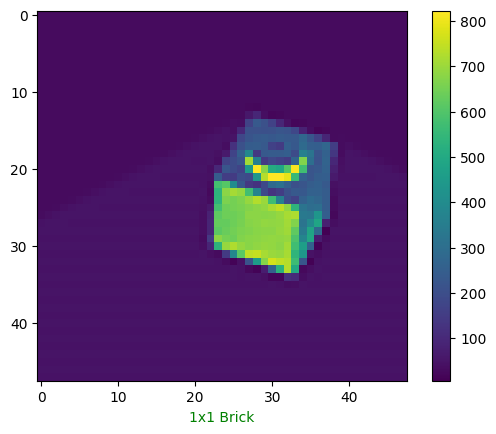

In [27]:
#nn
show_random(net, test_dataloader)